In [1]:
import pandas as pd
import numpy as np
from pandas.core.arrays.sparse import dtype
# from model_v1 import MinRiskByHistoricalVar
import matplotlib.pyplot as plt
import ffn
import dask.dataframe
import os
import warnings
import copy
import sklearn as sk
import cvxpy as cvx
import datetime
import matplotlib.pyplot as plt
os.chdir('/Users/arthur/Desktop/factor_investment')

(CVXPY) Jun 09 03:36:56 PM: Encountered unexpected exception importing solver SCS:
ImportError('dlopen(/opt/anaconda3/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so, 2): Symbol not found: _aligned_alloc\n  Referenced from: /opt/anaconda3/lib/python3.9/site-packages/scs/.dylibs/libgomp.1.dylib (which was built for Mac OS X 10.15)\n  Expected in: /usr/lib/libSystem.B.dylib\n in /opt/anaconda3/lib/python3.9/site-packages/scs/.dylibs/libgomp.1.dylib')


標準化個因子
考量市值大小
方向變化（正相關 負相關）
缺值等權合成
中性化（https://heatask.com/photograph/69198.html）


In [2]:
def nor(lis):
    lis = (np.array(lis) - np.nanmean(lis)) / (np.nanvar(lis))**(1/2)
    return lis

In [3]:
def get_optimal_weights(covariance_matrix):

    num_of_weights = covariance_matrix.shape[0]
    
    x = cvx.Variable(num_of_weights)
    
    portfolio_variance = cvx.quad_form(x, covariance_matrix)
    
    objective = cvx.Minimize(portfolio_variance)
    
    constraints = [x >= 0, sum(x) == 1]
   
    problem = cvx.Problem(objective, constraints)
    problem.solve()
    
    x_values = x.value
    return x_values

In [4]:
def mul(return_list):
    return_list = return_list[~(np.isnan(return_list))]
    new_return = 1
    for i in return_list:
        new_return = new_return*i
    
    return new_return

In [5]:
candidatePoolDF=pd.read_excel('./計算溢酬/CTBCdata/10個因子原始資料.xlsx','125檔', dtype=str,index_col=0,header=1)
# factor_size=pd.read_csv('./CTBCdata/419valuefactor.csv', index_col=0)
CTP=pd.read_excel('./計算溢酬/CTBCdata/factorvalues.xlsx','CTP', index_col=0)
EB=pd.read_excel('./計算溢酬/CTBCdata/factorvalues.xlsx','EB', index_col=0)
EP=pd.read_excel('./計算溢酬/CTBCdata/factorvalues.xlsx','EP', index_col=0)
MOM=pd.read_excel('./計算溢酬/CTBCdata/factorvalues.xlsx','MOM', index_col=0)
VOL=pd.read_excel('./計算溢酬/CTBCdata/factorvalues.xlsx','VOL', index_col=0)
SEN=pd.read_excel('./計算溢酬/CTBCdata/factorvalues_sentiment.xlsx','sentiment_2', index_col=0)

In [6]:
# NoBenchmarkPool=list(candidatePoolDF.index)
# candidatePool=['0050']+NoBenchmarkPool

candidatePool=list(candidatePoolDF.index)

candidatePool=[str(x) for x in candidatePool]
candidatePool.sort()
candidatePool = ['50']+candidatePool
print(candidatePool)
print(len(candidatePool))

['50', '1101', '1102', '1216', '1227', '1301', '1303', '1326', '1402', '1476', '1504', '1565', '1590', '1722', '1802', '2002', '2049', '2105', '2201', '2207', '2227', '2301', '2303', '2308', '2317', '2324', '2327', '2330', '2337', '2344', '2345', '2347', '2353', '2354', '2356', '2357', '2371', '2377', '2379', '2382', '2385', '2395', '2408', '2409', '2412', '2454', '2474', '2492', '2498', '2603', '2609', '2610', '2615', '2618', '2633', '2801', '2823', '2834', '2880', '2881', '2882', '2883', '2884', '2885', '2886', '2887', '2888', '2890', '2891', '2892', '2912', '2915', '3008', '3034', '3037', '3045', '3105', '3176', '3231', '3293', '3481', '3529', '3532', '3552', '3673', '3682', '3702', '3711', '4147', '4157', '4174', '4743', '4904', '4938', '4958', '4966', '5269', '5347', '5483', '5530', '5871', '5876', '5880', '5903', '5904', '6121', '6147', '6239', '6415', '6446', '6456', '6488', '6505', '6669', '8044', '8046', '8069', '8299', '8406', '8436', '8454', '8464', '9904', '9910', '9921', '

In [7]:
CTP = CTP[CTP.index.astype('str').isin(candidatePool)]
EB = EB[EB.index.astype('str').isin(candidatePool)]
EP = EP[EP.index.astype('str').isin(candidatePool)]
VOL = VOL[VOL.index.astype('str').isin(candidatePool)]
MOM= MOM[MOM.index.astype('str').isin(candidatePool)]
SEN = SEN[SEN.index.isin(CTP.index)]
#
CTP = CTP.loc[:, CTP.columns.isin(SEN.columns)]
EB = EB.loc[:, EB.columns.isin(SEN.columns)]
EP = EP.loc[:, EP.columns.isin(SEN.columns)]
VOL = VOL.loc[:, VOL.columns.isin(SEN.columns)]
MOM = MOM.loc[:, MOM.columns.isin(SEN.columns)]
#
CTP = CTP.fillna(np.nan)
EB = EB.fillna(np.nan)
EP = EP.fillna(np.nan)
VOL = VOL.fillna(np.nan)
MOM = MOM.fillna(np.nan)
SEN = SEN.fillna(np.nan)

In [8]:
weights_df = pd.DataFrame()
CTP_Value = copy.copy(CTP) # 標準化
EB_Value = copy.copy(EB)
EP_Value = copy.copy(EP)
VOL_Value = copy.copy(VOL)
MOM_Value = copy.copy(MOM)
SEN_Value = copy.copy(SEN)

for i in range(CTP.shape[1]):
#     index = CTP.iloc[:, i].values == CTP.iloc[:, i].values
    CTP_value = nor(CTP.iloc[:, i])
    CTP_Value.iloc[:, i] = CTP_value
    
    EB_value = nor(EB.iloc[:, i])
    EB_Value.iloc[:, i] = EB_value
    
    EP_value = nor(EP.iloc[:, i])
    EP_Value.iloc[:, i] = EP_value
    
    MOM_value = nor(MOM.iloc[:, i])
    MOM_Value.iloc[:, i] = MOM_value
    
    VOL_value = nor(VOL.iloc[:, i])
    VOL_Value.iloc[:, i] = VOL_value
    
    SEN_value = nor(SEN.iloc[:, i])
    SEN_Value.iloc[:, i] = SEN_value

for i in range(CTP.shape[1]):
    index = np.logical_and(CTP_Value.iloc[:, i].values == CTP_Value.iloc[:, i].values, EB_Value.iloc[:, i].values == EB_Value.iloc[:, i].values)
    index = np.logical_and(index, EP_Value.iloc[:, i].values == EP_Value.iloc[:, i].values)
    index = np.logical_and(index, MOM_Value.iloc[:, i].values == MOM_Value.iloc[:, i].values)
    index = np.logical_and(index, VOL_Value.iloc[:, i].values == VOL_Value.iloc[:, i].values)
    index = np.logical_and(index, SEN_Value.iloc[:, i].values == SEN_Value.iloc[:, i].values)
    
    try:
        CTP_value = CTP_Value.iloc[:, i].values[index]
        EB_value = EB_Value.iloc[:, i].values[index]
        EP_value = EP_Value.iloc[:, i].values[index]
        MOM_value = MOM_Value.iloc[:, i].values[index]
        VOL_value = VOL_Value.iloc[:, i].values[index]
        SEN_value = SEN_Value.iloc[:, i].values[index]
        
        covMatrix = np.cov(np.array([CTP_value, EB_value, EP_value, MOM_value, VOL_value, SEN_value]))

        weights_df[CTP.columns[i]] = get_optimal_weights(covMatrix)
    except:
        continue

In [9]:
weights_df

,2013-03-31,2013-05-31,2013-08-31,2013-11-30,2014-03-31,2014-05-31,2014-08-31,2014-11-30,2015-03-31,2015-05-31,...,2019-08-31,2019-11-30,2020-03-31,2020-05-31,2020-08-31,2020-11-30,2021-03-31,2021-05-31,2021-08-31,2021-11-30
0,0.138539,0.146860,0.161170,0.121420,1.892512e-01,0.167710,0.019629,0.178341,0.203027,0.182249,...,0.147933,0.130699,0.164853,0.120253,0.105237,0.152995,6.131264e-02,7.961159e-02,1.578669e-01,1.691978e-01
1,0.170981,0.058890,0.063654,0.070718,1.591251e-01,0.177041,0.099444,0.108292,0.132719,0.179648,...,0.300099,0.402011,0.167696,0.163155,0.188854,0.193167,3.374839e-01,2.439195e-02,7.237720e-02,-3.435814e-23
2,0.118783,0.152046,0.100827,0.048835,6.519881e-24,0.158014,0.372902,0.133922,0.035699,0.028540,...,0.091203,0.010328,0.060356,0.185877,0.181393,0.048699,4.102685e-23,4.219103e-24,3.431498e-23,-3.811236e-23
3,0.234486,0.280337,0.310753,0.229283,2.893217e-01,0.253312,0.246806,0.250465,0.255315,0.229459,...,0.166490,0.186526,0.250389,0.234919,0.208671,0.213075,1.333414e-01,1.239613e-01,2.159367e-01,2.140530e-01
4,0.224874,0.210553,0.210441,0.389527,1.521157e-01,0.145071,0.127562,0.116935,0.128244,0.125849,...,0.124908,0.059211,0.154086,0.126066,0.146929,0.163371,2.818632e-01,6.428106e-01,4.203692e-01,4.361101e-01
5,0.112336,0.151315,0.153157,0.140217,2.101863e-01,0.098853,0.133657,0.212045,0.244995,0.254255,...,0.169368,0.211225,0.202621,0.169730,0.168916,0.228693,1.859988e-01,1.292245e-01,1.334499e-01,1.806392e-01


In [10]:
current_index = pd.DataFrame()
for i in weights_df.columns:
    weight = weights_df[i]
    current_index[i] = weight[0]*CTP_Value[i] + weight[1]*EB_Value[i] + weight[2]*EP_Value[i] + weight[3]*MOM_Value[i] + weight[4]*VOL_Value[i] + weight[5]*SEN[i]

In [11]:
current_index.index = current_index.index.astype('str')
current_index = current_index[current_index.index.isin(candidatePool)]
current_index

,2013-03-31,2013-05-31,2013-08-31,2013-11-30,2014-03-31,2014-05-31,2014-08-31,2014-11-30,2015-03-31,2015-05-31,...,2019-08-31,2019-11-30,2020-03-31,2020-05-31,2020-08-31,2020-11-30,2021-03-31,2021-05-31,2021-08-31,2021-11-30
1101,0.903595,0.806285,0.639127,1.066322,1.751442,-0.042182,0.796560,1.459780,-0.079304,0.023870,...,0.255320,0.283281,0.241124,3.095758,0.529894,2.579774,2.320880,0.067993,-0.169136,-0.400139
1102,0.838533,NaN,-0.663428,1.019586,-0.198432,-0.321046,0.320189,0.995870,3.366984,0.053828,...,0.255158,1.664074,0.930061,0.037560,0.450572,2.575484,-0.157533,0.212686,-0.182088,0.122001
1216,1.316340,-0.163750,-0.146681,0.941500,0.685052,-0.305911,0.209061,1.261301,0.992634,0.331714,...,2.449664,0.076604,0.626773,3.224242,-0.418756,2.736669,0.248843,-1.200540,1.073625,0.537607
1227,-0.373125,-1.540683,-1.633070,NaN,NaN,NaN,NaN,-0.543959,-0.120079,NaN,...,-0.358136,0.077576,-0.226521,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1301,0.497201,-0.610398,-1.137142,0.440228,0.699531,-0.216836,0.192051,0.939319,-1.218585,-0.011113,...,-0.016746,0.967909,-1.496031,-0.701426,-0.090401,0.421068,-0.884845,1.010706,2.279124,0.519932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.415278,NaN,NaN,NaN,NaN
9904,1.990119,1.949697,2.561922,2.434902,-2.496176,0.095469,0.444672,0.319431,1.099199,0.350109,...,0.806212,NaN,-0.104716,0.866261,NaN,0.329456,NaN,0.246916,0.226806,NaN
9910,0.310525,NaN,NaN,NaN,2.141409,1.611195,2.084402,1.142063,3.790693,0.210157,...,0.225795,NaN,-0.772280,-0.097059,-0.898417,NaN,0.086485,NaN,NaN,NaN
9921,3.997368,-0.168557,0.310798,1.505197,3.197927,1.180657,1.393725,1.133473,8.634879,0.081353,...,4.605919,2.764197,1.791847,1.024483,1.537278,NaN,0.166428,2.241269,3.177203,NaN


In [12]:
def group(factor_df):
    high_group = pd.DataFrame()

    for i in factor_df.columns:
        values = factor_df.loc[:, i].values
        values = values[~np.isnan(values)]
        num = round(len(values)/5)
        top_index = factor_df.index[ np.argpartition(values, -num)[-num:] ]

        df = pd.DataFrame({i:top_index})
        high_group = pd.concat([high_group, df], ignore_index=True, axis=1)

    high_group.columns = factor_df.columns
    return high_group

In [13]:
selected_stock = group(current_index)
selected_stock = selected_stock.astype('str')
selected_stock.columns = selected_stock.columns.date

In [14]:
selected_stock

,2013-03-31,2013-05-31,2013-08-31,2013-11-30,2014-03-31,2014-05-31,2014-08-31,2014-11-30,2015-03-31,2015-05-31,...,2019-08-31,2019-11-30,2020-03-31,2020-05-31,2020-08-31,2020-11-30,2021-03-31,2021-05-31,2021-08-31,2021-11-30
0,3481,2337,2633,2353,1590,3045,2227,2633,2344,2610,...,3529,2371,4157,3176,2308,3552,1326,2454,1301,2207
1,2412,2610,2105,2327,2498,3293,2395,2603,1476,3682,...,2337,2344,2207,3008,3105,3529,2357,2615,3037,1802
2,2357,2354,2201,3045,3037,3176,3711,2324,1802,3529,...,2317,2379,3034,2610,3231,1216,3034,2301,2327,2615
3,2201,2633,2357,2357,2474,3682,2474,3552,3176,2412,...,3008,3532,2915,2344,2609,2385,3045,3481,1227,2344
4,2303,1802,3037,2618,2356,1722,3045,3532,3045,2615,...,4904,3293,4958,2201,3293,2412,3105,2308,3176,3529
5,3045,2207,3105,1476,2412,2412,3037,2345,1102,2618,...,2412,3673,2609,2354,3481,2603,2633,3532,3231,2474
6,3105,3105,2337,3034,3034,3037,2330,1504,3105,3105,...,2915,2227,3481,2357,3176,1722,2618,2409,2382,3045
7,1476,2615,3231,3231,3293,2344,2303,3231,3008,2344,...,2344,2912,2615,3105,2317,2618,3293,2379,2492,2915
8,2344,2498,2395,2915,3481,2303,2408,3045,1303,2353,...,2609,2498,2412,2492,3034,2345,2498,3529,2049,2412
9,2610,2454,3481,1504,2915,1301,2912,3702,1402,3176,...,4174,3481,3702,2345,3008,3008,2371,2915,1590,2377


In [15]:
# AllStockReturn=pd.DataFrame()
# for stock in candidatePool+['0050']:
#     data=pd.read_csv('./data/price/'+str(stock)+'.csv')

#     if stock==candidatePool[0]:
#         AllStockReturn=data[['Date','return']]
#         AllStockReturn=AllStockReturn.rename(columns={'return':str(stock)})
#     else:
#         AllStockReturn=AllStockReturn.merge(data[['Date','return']],on='Date',how='left')
#         AllStockReturn=AllStockReturn.rename(columns={'return':str(stock)})
# AllStockReturn=AllStockReturn[AllStockReturn['Date']>'2010-03-30']
# # AllStockReturn=AllStockReturn[AllStockReturn['Date']>'2013-04-30']
# dates=AllStockReturn['Date'].values
# AllStockReturn=AllStockReturn.reset_index(drop=True)
# AllStockReturn.index = AllStockReturn.iloc[:, 0].values
# AllStockReturn = AllStockReturn.iloc[:, 1:]
# AllStockReturn

col_list = ["證券代碼", "簡稱", "年月日", "收盤價(元)"]
price = pd.read_csv('./data/TEJ_StockPrice_20052022.csv', encoding='big5', encoding_errors='ignore', usecols=col_list)
price["證券代碼"] = [str(x).strip() for x in price["證券代碼"]]
price["簡稱"] = [x.strip() for x in price["簡稱"]]
price.年月日 = pd.to_datetime(price.年月日).dt.date

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_3068/1559867022.py:20: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  price = pd.read_csv('./data/TEJ_StockPrice_20052022.csv', encoding='big5', encoding_errors='ignore', usecols=col_list)


In [16]:
price

,證券代碼,簡稱,年月日,收盤價(元)
0,1,野村鴻運基金,2005-01-03,6.95
1,1,野村鴻運基金,2005-01-04,6.75
2,1,野村鴻運基金,2005-01-05,6.65
3,1,野村鴻運基金,2005-01-06,6.75
4,1,野村鴻運基金,2005-01-07,6.65
...,...,...,...,...
9239068,ZGT50,富櫃50指數,2022-05-10,225.81
9239069,ZGT50,富櫃50指數,2022-05-11,225.18
9239070,ZGT50,富櫃50指數,2022-05-12,220.83
9239071,ZGT50,富櫃50指數,2022-05-13,228.28


In [17]:
prices = pd.DataFrame(columns = candidatePool)
for i in price.index:
    coid = price.loc[i, "證券代碼"]
    if coid in candidatePool: # 只抓125檔的價格
        date = price.loc[i, "年月日"]
        close = price.loc[i, "收盤價(元)"]
        prices.loc[date, coid] = close
        if (i % 10000) == 0:
            print(i//10000, end=' ')

33 46 53 63 88 163 173 178 179 183 185 188 191 194 196 202 204 205 206 211 216 275 294 296 302 304 305 314 320 333 420 432 433 438 464 489 535 543 623 625 639 763 845 

In [18]:
prices.index[0]

datetime.date(2005, 1, 3)

In [19]:
pd.date_range(start='2005-01-03', end='2022-05-16').date

array([datetime.date(2005, 1, 3), datetime.date(2005, 1, 4),
       datetime.date(2005, 1, 5), ..., datetime.date(2022, 5, 14),
       datetime.date(2022, 5, 15), datetime.date(2022, 5, 16)],
      dtype=object)

In [20]:
prices.index[0] in pd.date_range(start='2005-01-03', end='2022-05-16').date

True

In [21]:
for i in pd.date_range(start='2005-01-03', end='2022-05-16').date:
    if i not in prices.index.values:
#         print(i)
        prices.loc[i, :] = [np.nan]*126

prices = prices.sort_index()
prices = prices.fillna(method='ffill')
prices

,50,1101,1102,1216,1227,1301,1303,1326,1402,1476,...,8069,8299,8406,8436,8454,8464,9904,9910,9921,9945
2005-01-03,26.0412,6.5323,6.1152,5.8378,2.3827,18.8739,17.9835,20.0158,8.9404,4.6637,...,10.9381,12.1654,NaN,NaN,NaN,NaN,10.0803,7.8539,24.3832,2.3774
2005-01-04,25.6045,6.4407,5.9805,5.6989,2.3539,18.3592,17.8358,19.6822,8.7664,4.5837,...,10.8129,12.0171,NaN,NaN,NaN,NaN,9.9059,7.9208,24.3832,2.3172
2005-01-05,25.2702,6.4102,5.8997,5.5946,2.3061,18.3592,17.4296,19.3486,8.6273,4.5571,...,10.7294,11.9429,NaN,NaN,NaN,NaN,9.8013,7.9208,24.3832,2.2570
2005-01-06,25.2702,6.3492,5.8728,5.5599,2.3252,18.1876,17.3927,19.1818,8.3838,4.5571,...,10.3537,11.8687,NaN,NaN,NaN,NaN,9.8013,7.8985,25.7131,2.3022
2005-01-07,25.0708,6.1050,5.7650,5.4904,2.3252,18.0160,17.2819,19.3486,8.2446,4.5837,...,10.0197,11.5720,NaN,NaN,NaN,NaN,9.6617,7.8985,25.4915,2.3323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-12,121.2500,40.8000,44.4000,65.3000,47.0000,100.5000,82.1000,76.1000,29.7000,500.0000,...,165.5000,370.0000,278.5,140.0,708.0,303.5,29.0000,170.0000,223.5000,69.8000
2022-05-13,122.3500,41.6000,45.0500,65.2000,47.6500,102.5000,82.0000,77.2000,31.0000,512.0000,...,169.0000,378.5000,278.5,144.5,740.0,312.5,29.0000,175.0000,233.5000,71.5000
2022-05-14,122.3500,41.6000,45.0500,65.2000,47.6500,102.5000,82.0000,77.2000,31.0000,512.0000,...,169.0000,378.5000,278.5,144.5,740.0,312.5,29.0000,175.0000,233.5000,71.5000
2022-05-15,122.3500,41.6000,45.0500,65.2000,47.6500,102.5000,82.0000,77.2000,31.0000,512.0000,...,169.0000,378.5000,278.5,144.5,740.0,312.5,29.0000,175.0000,233.5000,71.5000


In [22]:
selected_stock.columns[0] + datetime.timedelta(days=30)

datetime.date(2013, 4, 30)

In [23]:
return_df = pd.DataFrame( index = [0, 1], columns=pd.date_range( start=str(selected_stock.columns[0]+datetime.timedelta(days=30)), end=str(selected_stock.columns[-1]+ datetime.timedelta(days=120)) ).date )
cumu_return = copy.copy(return_df)
# num_buy = copy.copy(selected_stock)


for j in range(selected_stock.shape[1]):
    start_date = selected_stock.columns[j] + datetime.timedelta(days=30)
    end_date = selected_stock.columns[j] + datetime.timedelta(days=120)
    print(start_date, end_date)
    
    for i in range(selected_stock.shape[0]):
        if selected_stock.iloc[i, j] != 'nan':
            stock_coid = selected_stock.iloc[i, j]
            stock_buying_price = prices.loc[start_date, stock_coid]
#             stock_buying_num = 100/stock_buying_price
#             num_buy.iloc[i, j] = stock_buying_num

            for k in pd.date_range(start=start_date, end=end_date).date:
                stock_selling_price = prices.loc[k, stock_coid]
                stock_odbselling_price = prices.loc[k-datetime.timedelta(days=1), stock_coid] # one-date-before -> odb
                if k != end_date:
                    return_df.loc[0, k] = np.append(return_df.loc[0, k], stock_selling_price/stock_odbselling_price)
                else:
                    return_df.loc[0, k] = np.append(return_df.loc[0, k], stock_selling_price*0.997/stock_odbselling_price)


# return_df= pd.DataFrame()

# for j in range(selected_stock.shape[1]):
#     start_date = selected_stock.columns[j] + datetime.timedelta(days=30)
#     end_date = selected_stock.columns[j] + datetime.timedelta(days=120)
#     print(start_date, end_date)
    
#     for k in pd.date_range(start=start_date, end=end_date):
#         print(k)
#         return_list = []
#         for i in range(selected_stock.shape[0]):
#             if selected_stock.iloc[i, j] != 'nan':
#                 col_name = selected_stock.iloc[i, j]
#                 if len(AllStockReturn.loc[AllStockReturn.index.astype('datetime64[ns]') == k, col_name].values) != 0:
#                     return_list.append( AllStockReturn.loc[AllStockReturn.index.astype('datetime64[ns]') == k, col_name].values[0] )

#         return_list = [x for x in return_list if np.isnan(x) == False]
#         try:
#             return_df.loc[0, k] += 0.01*sum(return_list)/len(return_list)
#         except:
#             try:
#                 return_df.loc[0, k] = 1 + 0.01*sum(return_list)/len(return_list)
#             except:
#                 return_df.loc[0, k] = 1
    
# #     high_return = []
# #     for i in range(selected_stock.shape[0]):
# #         if selected_stock.iloc[i, j] != 'nan':
# #             print(i, j)
# #             col_name = selected_stock.iloc[i, j]
# #             high_return.append( mul(AllStockReturn.loc[(AllStockReturn.index.astype('datetime64[ns]').date > start_date) & (AllStockReturn.index.astype('datetime64[ns]').date < end_date), col_name]) )

# #     return_df.loc[0, start_date] = (sum(high_return)/len(high_return))

2013-04-30 2013-07-29
2013-06-30 2013-09-28
2013-09-30 2013-12-29
2013-12-30 2014-03-30
2014-04-30 2014-07-29
2014-06-30 2014-09-28
2014-09-30 2014-12-29
2014-12-30 2015-03-30
2015-04-30 2015-07-29
2015-06-30 2015-09-28
2015-09-30 2015-12-29
2015-12-30 2016-03-29
2016-04-30 2016-07-29
2016-06-30 2016-09-28
2016-09-30 2016-12-29
2016-12-30 2017-03-30
2017-04-30 2017-07-29
2017-06-30 2017-09-28
2017-09-30 2017-12-29
2017-12-30 2018-03-30
2018-04-30 2018-07-29
2018-06-30 2018-09-28
2018-09-30 2018-12-29
2018-12-30 2019-03-30
2019-04-30 2019-07-29
2019-06-30 2019-09-28
2019-09-30 2019-12-29
2019-12-30 2020-03-29
2020-04-30 2020-07-29
2020-06-30 2020-09-28
2020-09-30 2020-12-29
2020-12-30 2021-03-30
2021-04-30 2021-07-29
2021-06-30 2021-09-28
2021-09-30 2021-12-29
2021-12-30 2022-03-30


In [24]:
for j in range(selected_stock.shape[1]):
    start_date = selected_stock.columns[j] + datetime.timedelta(days=30)
    end_date = selected_stock.columns[j] + datetime.timedelta(days=120)
    print(start_date, end_date)
    

    stock_coid = '50'
    stock_buying_price = prices.loc[start_date, stock_coid]
#     stock_buying_num = 100/stock_buying_price

    for k in pd.date_range(start=start_date, end=end_date).date:
        stock_selling_price = prices.loc[k, stock_coid]
        stock_odbselling_price = prices.loc[k-datetime.timedelta(days=1), stock_coid]
        if k != end_date:
            return_df.loc[1, k] = np.append(return_df.loc[1, k], stock_selling_price/stock_odbselling_price)
        else:
            return_df.loc[1, k] = np.append(return_df.loc[1, k], stock_selling_price*0.997/stock_odbselling_price)

2013-04-30 2013-07-29
2013-06-30 2013-09-28
2013-09-30 2013-12-29
2013-12-30 2014-03-30
2014-04-30 2014-07-29
2014-06-30 2014-09-28
2014-09-30 2014-12-29
2014-12-30 2015-03-30
2015-04-30 2015-07-29
2015-06-30 2015-09-28
2015-09-30 2015-12-29
2015-12-30 2016-03-29
2016-04-30 2016-07-29
2016-06-30 2016-09-28
2016-09-30 2016-12-29
2016-12-30 2017-03-30
2017-04-30 2017-07-29
2017-06-30 2017-09-28
2017-09-30 2017-12-29
2017-12-30 2018-03-30
2018-04-30 2018-07-29
2018-06-30 2018-09-28
2018-09-30 2018-12-29
2018-12-30 2019-03-30
2019-04-30 2019-07-29
2019-06-30 2019-09-28
2019-09-30 2019-12-29
2019-12-30 2020-03-29
2020-04-30 2020-07-29
2020-06-30 2020-09-28
2020-09-30 2020-12-29
2020-12-30 2021-03-30
2021-04-30 2021-07-29
2021-06-30 2021-09-28
2021-09-30 2021-12-29
2021-12-30 2022-03-30


In [25]:
for i in range(len(return_df.columns)):
    return_df.iloc[0, i] = np.nanmean(return_df.iloc[0, i] )
    return_df.iloc[1, i] = np.nanmean(return_df.iloc[1, i] )

return_df = return_df.fillna(1)

return_df

/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_3068/3366130712.py:2: RuntimeWarning: Mean of empty slice
  return_df.iloc[0, i] = np.nanmean(return_df.iloc[0, i] )
/var/folders/w8/jwxq4stj29506b1pf67xpb000000gq/T/ipykernel_3068/3366130712.py:3: RuntimeWarning: Mean of empty slice
  return_df.iloc[1, i] = np.nanmean(return_df.iloc[1, i] )


,2013-04-30,2013-05-01,2013-05-02,2013-05-03,2013-05-04,2013-05-05,2013-05-06,2013-05-07,2013-05-08,2013-05-09,...,2022-03-21,2022-03-22,2022-03-23,2022-03-24,2022-03-25,2022-03-26,2022-03-27,2022-03-28,2022-03-29,2022-03-30
0,1.008844,1.0,1.004628,0.999990,1.0,1.0,1.011645,0.997733,1.008364,0.999758,...,1.000020,0.998788,1.007231,0.987748,0.993569,1.0,1.0,0.993329,1.003187,1.004003
1,1.010754,1.0,1.002659,1.001769,1.0,1.0,1.004411,1.003515,1.013136,1.006049,...,1.006613,0.998540,1.009503,0.999276,1.001449,1.0,1.0,0.989146,1.001097,1.009385


In [27]:
cumu_return = copy.copy(return_df)

for i in range(len(return_df.iloc[0, :])):
    if i != 0:
        cumu_return.iloc[0, i] = cumu_return.iloc[0, i-1] * cumu_return.iloc[0, i]

for i in range(len(return_df.iloc[1, :])):
    if i != 0:
        cumu_return.iloc[1, i] = cumu_return.iloc[1, i-1] * cumu_return.iloc[1, i]

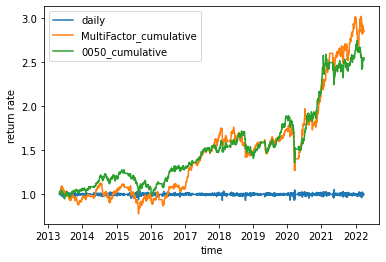

In [28]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(return_df.columns, return_df.iloc[0, :], label='daily')
ax.plot(cumu_return.columns, cumu_return.iloc[0, :], label='MultiFactor_cumulative')
# ax.plot(return_df.columns, return_df.iloc[1, :], label='0050_daily')
ax.plot(cumu_return.columns, cumu_return.iloc[1, :], label='0050_cumulative')
ax.set_xlabel('time')  # Add an x-label to the axes.
ax.set_ylabel('return rate')  # Add a y-label to the axes.
ax.legend();  # Add a legend.